# 💬 TMCD – Trabalho Final
## Análise de Sentimentos em Reviews de Filmes

### 👥 Grupo Trab-grupo-30
- **Rafael Alexandre Dias Andorinha**, nº 131000  
- **Pedro Fonte Santa**, nº 105306  

---

📅 **Data de entrega:** 26 de abril  

📊 **Objetivo deste script:**
Este Notebook corresponde à Tarefa 2.5 do trabalho.

O objetivo desta etapa é aplicar um modelo pré-treinado baseado em transformadores ao problema de análise de sentimentos no dataset IMDB. A tarefa foi realizado no Google Colab com GPU e dividida em duas fases:

- **Etapa a)**: aplicação direta de um modelo pré-treinado (`distilbert-base-uncased-finetuned-sst-2-english`) através do pipeline da biblioteca Hugging Face, permitindo uma avaliação rápida sem necessidade de treino adicional.

- **Etapa b)**: fine-tuning do modelo `distilbert-base-uncased` com os dados reais do projeto, utilizando PyTorch puro. Esta abordagem foi adotada após dificuldades técnicas com o `Trainer` da Hugging Face, garantindo total controlo sobre o processo de treino e compatibilidade com o ambiente de execução.

A implementação foi inspirada no notebook da aula "BERT-based classification", tendo sido adaptada para suportar um processo manual de treino, preparação de batches e avaliação de métricas. No final comparamos os resultados.

---

# 🗂️ Dataset: IMDB Reviews

### 📘 Etapa a) — Pipeline direto com Hugging Face

In [ ]:
!pip install transformers datasets evaluate --quiet
!pip install torch

In [ ]:
from transformers import pipeline
import pandas as pd
from sklearn.metrics import classification_report
from tqdm import tqdm
import torch

In [27]:
print('Cuda Avaliable: ', torch.cuda.is_available())

Cuda Avaliable:  True


In [ ]:
df_test = pd.read_csv('../dataset/imdb_reviews_test.csv')

In [ ]:
clf = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    framework="pt"  # <-- forçar a usar PyTorch
)

Device set to use cpu


In [ ]:
texts = df_test['text'].tolist()
batch_size = 32
preds = []

# Processar por batches com barra de progresso
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    preds.extend(clf(batch, truncation=True))

df_test['pred_pipeline'] = [p['label'].lower() for p in preds]

100%|██████████| 688/688 [2:23:02<00:00, 12.47s/it]  


In [ ]:
# Converter as predições do pipeline para o mesmo formato dos rótulos
df_test['pred_pipeline'] = df_test['pred_pipeline'].map({'positive': 'pos', 'negative': 'neg'})

In [ ]:
print(df_test['label'].unique())
print(df_test['pred_pipeline'].unique())

['pos' 'neg']
['positive' 'negative']


In [ ]:
print(classification_report(
    df_test['label'],
    df_test['pred_pipeline'],
    target_names=['neg', 'pos']
))

              precision    recall  f1-score   support

         neg       0.89      0.92      0.90     11050
         pos       0.91      0.89      0.90     10946

    accuracy                           0.90     21996
   macro avg       0.90      0.90      0.90     21996
weighted avg       0.90      0.90      0.90     21996



### ⚙️ Etapa b) – Fine-tuning com PyTorch

In [ ]:
!pip install transformers datasets evaluate --quiet


In [4]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Lê os teus ficheiros CSV diretamente do Drive
df_train = pd.read_csv("/content/drive/MyDrive/ISCTE/Mestrado/projeto/dataset/imdb_reviews_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/ISCTE/Mestrado/projeto/dataset/imdb_reviews_test.csv")

# Mapear 'pos' e 'neg' para 1 e 0
label_map = {'pos': 1, 'neg': 0}
df_train['label'] = df_train['label'].map(label_map)
df_test['label'] = df_test['label'].map(label_map)


Mounted at /content/drive


In [6]:
train_ds = Dataset.from_pandas(df_train[['text', 'label']])
test_ds = Dataset.from_pandas(df_test[['text', 'label']])
dataset = DatasetDict({'train': train_ds, 'test': test_ds})


In [20]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example['text'], padding=True, truncation=True)

dataset_tokenized = dataset.map(tokenize, batched=True)


Map:   0%|          | 0/21754 [00:00<?, ? examples/s]

Map:   0%|          | 0/21996 [00:00<?, ? examples/s]

In [21]:
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

train_dataloader = DataLoader(tokenized_train, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_test, batch_size=16)


In [22]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model.train()
num_epochs = 2

for epoch in range(num_epochs):
    print(f"\n Época {epoch + 1}")
    loop = tqdm(train_dataloader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        loop.set_description(f"Época {epoch + 1}")
        loop.set_postfix(loss=loss.item())



 Época 1


Época 1: 100%|██████████| 1360/1360 [17:25<00:00,  1.30it/s, loss=0.0672]



 Época 2


Época 2: 100%|██████████| 1360/1360 [17:24<00:00,  1.30it/s, loss=0.215]


In [25]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("\n📊 Resultados do modelo fine-tuned:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precisão:  {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")



📊 Resultados do modelo fine-tuned:
Accuracy:  0.937
Precisão:  0.945
Recall:    0.927
F1 Score:  0.936


### 📊 Comparação de Resultados — Etapa a) vs Etapa b)

| Métrica   | Etapa a) - Pipeline HF | Etapa b) - Fine-tuning PyTorch | Diferença |
|-----------|------------------------|-------------------------------|-----------|
| Accuracy  | 0.900                  | 0.937                         | +0.037    |
| Precisão  | 0.910 (positiva)       | 0.945                         | +0.035    |
| Recall    | 0.890 (positiva)       | 0.927                         | +0.037    |
| F1 Score  | 0.900                  | 0.936                         | +0.036    |


> A realização de fine-tuning com os dados do IMDB demonstrou ganhos claros em todas as métricas em comparação com o modelo genérico usado na etapa a).


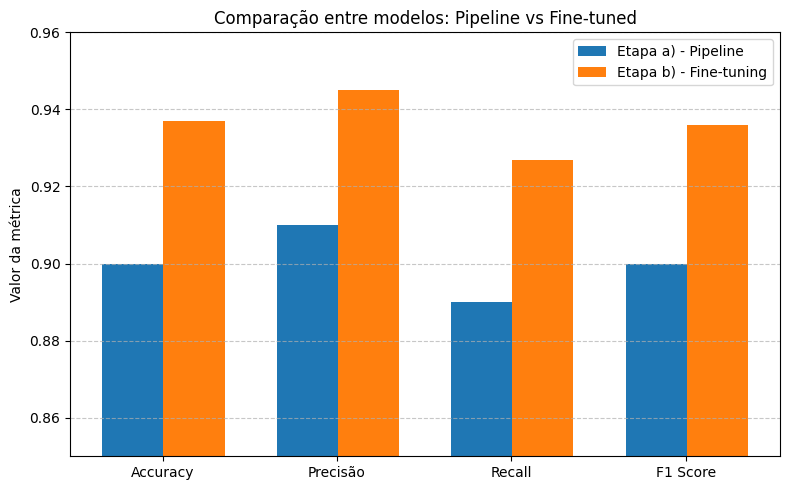

In [26]:
import matplotlib.pyplot as plt

metricas = ['Accuracy', 'Precisão', 'Recall', 'F1 Score']
etapa_a = [0.900, 0.910, 0.890, 0.900]
etapa_b = [0.937, 0.945, 0.927, 0.936]

x = range(len(metricas))
plt.figure(figsize=(8, 5))
plt.bar(x, etapa_a, width=0.35, label='Etapa a) - Pipeline', align='center')
plt.bar([i + 0.35 for i in x], etapa_b, width=0.35, label='Etapa b) - Fine-tuning', align='center')

plt.xticks([i + 0.17 for i in x], metricas)
plt.ylim(0.85, 0.96)
plt.ylabel('Valor da métrica')
plt.title('Comparação entre modelos: Pipeline vs Fine-tuned')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
